In [11]:
import matplotlib.pyplot as plt
import numpy as np
from pylbm import lbm
from scipy.optimize import curve_fit

In [2]:
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

epochs = 1000
eps = 0.01
omegas = np.arange(0.1, 1.51, 0.2).round(decimals=1)
r_mean, u_mean = 1, 0.
i_dim, j_dim = 120, 100
x = np.arange(i_dim)
y = np.arange(j_dim)
X, Y = np.meshgrid(x, y)

### Choose an initial distribution of  $ρ(r,t)$  and  $u(r,t)$  at  $t=0$  such as  $ρ(r,0)=ρ_0+ε \sin(2πx / L_x)$  and  $u(r,0)=0$ . Where  $L_x$  is the length of the domain in the  $x$  direction. Observe what happens with the 2D density distribution in time.

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

# epochs = 100
# omegas = np.array([0.5])

vs_emp = []
densities_omega_05 = []
for omega in omegas:
    r_ij = lbm.rho_init(i_dim=i_dim, j_dim=j_dim, r_mean=r_mean, eps=0.0)
    r_ij += eps * np.sin(2.0 * np.pi / i_dim * X).T

    u_aij = lbm.local_avg_velocity_init(i_dim=i_dim, j_dim=j_dim, u_mean=u_mean, eps=0.)
    f_cij = lbm.f_eq(u_aij=u_aij, r_ij=r_ij)

    densities = []
    for e in range(epochs):
        # use max density (j dim doesn't matter)
        densities.append(r_ij[i_dim//4,0])
        f_cij = lbm.stream(f_cij=f_cij)
        f_cij, u_aij = lbm.collision(f_cij=f_cij, omega=omega)
        r_ij = lbm.rho(f_cij=f_cij)
    if omega == 0.5:
        densities_omega_05 = densities.copy()

    def func(x, a, b, c, d):
        return a * np.cos(b * x) * np.exp(-c*x) + d
    popt, pcov = curve_fit(func, np.arange(epochs), densities)
    v = popt[2]/(2*np.pi/i_dim)**2
    vs_emp.append(popt[2]/(2*np.pi/i_dim)**2)

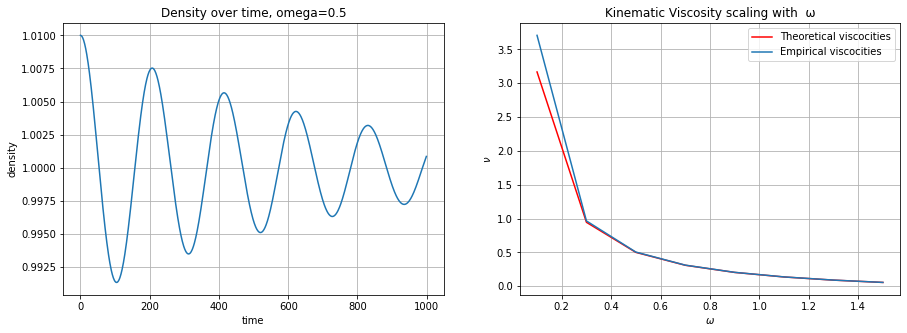

In [4]:
fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=1)
ax = axs[0]
densities_omega_05 = np.array(densities_omega_05)
ax.plot(np.arange(epochs),densities_omega_05)
ax.set_title("Density over time, omega=0.5")
ax.set_xlabel("time")
ax.set_ylabel("density")
ax.grid(True)
# ax.legend()

# messen geht nur uber gescwhindigkeit
# ax = axs[1]
# vs_theo = 1/3*(1/omegas-0.5)
# ax.plot(omegas,vs_theo, color='red', label='Theoretical viscocities')
# ax.plot(omegas,vs_emp,label='Empirical viscocities')
# ax.set_title("Kinematic Viscosity scaling with  ω")
# ax.set_xlabel(r'$\omega$')
# ax.set_ylabel(r'$\nu$')
# ax.grid(True)
# ax.legend()
# # fig.savefig("./m3_1")
# plt.show()

### M3.2 Choose an initial distribution of  $ρ(r,0)=1$  and  $u_x(r,0)=ε\sin(2πy / L_y)$ , i.e. a sinusoidal variation of the velocities  $u_x$  with the position  $y$ . Observe in both cases what happens dynamically as well as in the long time limit  $t→∞$ .

#### Milestone 1 must have Decaying amplitude graph
The amplitude at a given time t is given by

$ a(t)=1*e^-v * k^2 * t $   

$ k=zeta=\zeta = 2\pi / L_{x-or-y}$

The normailzed decaying amplitude graph is: $a(t)/a(0)$

In [5]:
# epochs = 200

velocities_omega_05 = []
amps_total = []
for omega in omegas:
    r_ij = lbm.rho_init(i_dim=i_dim, j_dim=j_dim, r_mean=r_mean, eps=0.0)

    u_aij = lbm.local_avg_velocity_init(i_dim=i_dim, j_dim=j_dim, u_mean=0.0, eps=0.)
    u_aij[0] += eps * np.sin(2.0 * np.pi / j_dim * Y).T
    # plt.imshow(u_aij[0])
    # plt.show()
    # break
    f_cij = lbm.f_eq(u_aij=u_aij, r_ij=r_ij)

    amps_emp = []
    for e in range(epochs):
        densities.append(r_ij[i_dim//4,0])
        epochs_print = 20
        if e%epochs_print==0 and omega == 0.5:
            # choose any i value, j values are the same
            velocities_omega_05.append([u_aij[0,0,:], e])
        
        amp = u_aij[0,0,:]

        amps_emp.append(amp.max()-amp.mean())

        f_cij = lbm.stream(f_cij=f_cij)
        f_cij, u_aij = lbm.collision(f_cij=f_cij, omega=omega)
        r_ij = lbm.rho(f_cij=f_cij)
        
    # break
    amps_emp = np.array(amps_emp)
    amps_total.append([omega, amps_emp])

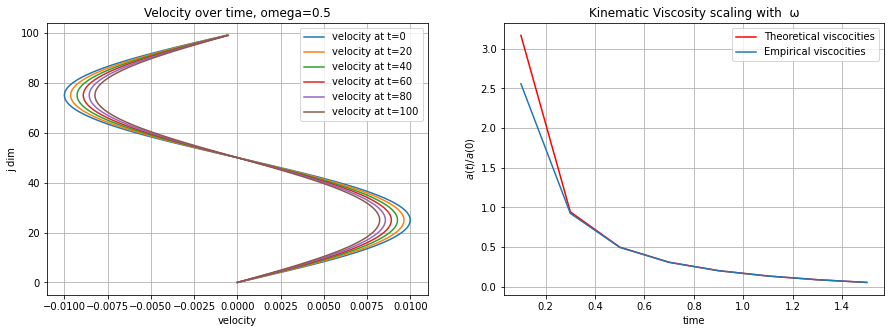

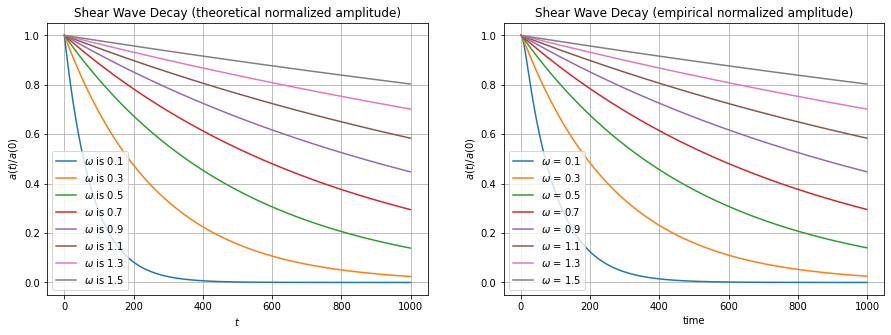

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
ax.set_title("Velocity over time, omega=0.5")
ax.set_xlabel("velocity")
ax.set_ylabel("j dim")
for v in velocities_omega_05[:6]:
    ax.plot(v[0],np.arange(j_dim), label="velocity at t={}".format(v[1]))
ax.legend()
ax.grid()

ax = axs[1]
nys_emp = []
for a in amps_total:
    def func(x, a):
        return np.exp(-a*(2*np.pi/j_dim)**2*x)
        # return np.exp(-a*x)
    popt, pcov = curve_fit(func, np.arange(epochs), a[1]/a[1][0] )
    nys_emp.append(popt[0])
ax.plot(omegas,vs_theo, color='red', label='Theoretical viscocities')
ax.plot(omegas,nys_emp,label='Empirical viscocities')
ax.set_title("Kinematic Viscosity scaling with  ω")
ax.set_xlabel('time')
ax.set_ylabel('$a(t)/a(0)$')
ax.legend()
ax.grid()

plt.show()

fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
plots = []
for omega in omegas:
    amplitudes = []
    for e in range(epochs):
        v = 1/3*(1/omega - 1/2)
        a = np.exp(-v*(2*np.pi/j_dim)**2*e)
        amplitudes.append(a)
    plots.append([omega, amplitudes])
for p in plots:
    ax.plot(np.arange(epochs), p[1], label="$\omega$ is {}".format(p[0].round(1)))
ax.set_title("Shear Wave Decay (theoretical normalized amplitude)")
ax.set_xlabel('$t$')
ax.set_ylabel('$a(t)/a(0)$')
ax.legend()
ax.grid()

ax = axs[1]
for a in amps_total:
    ax.plot(np.arange(epochs), a[1]/a[1][0], label='$\omega$ = {}'.format(a[0].round(1)))
ax.set_title("Shear Wave Decay (empirical normalized amplitude)")
ax.set_xlabel('time')
ax.set_ylabel('$a(t)/a(0)$')
ax.legend()
ax.grid()
# fig.savefig("./m3_2")

### Assume that the initial conditions fulfill the Stokes flow condition, i.e. $∂u/∂t=νΔu$ and calculate the kinematic viscosity. How does the kinematic viscosity scale with  $ω$? Compare the numerical decay of the initial perturbation (for both case 1 and case 2) with the theoretical one.
##### The report should contain a plot of the measured viscosity versus the parameter $ω$ . That plot should also contain the analytical prediction for this dependency  $ν=1/3(1/ω−1/2)$ .

Kinematic velocity equation $1/3*(1/ \omega - 1/2)$ applies if $\Delta x = 1$ and $\Delta t = 1$

See https://ilias.uni-freiburg.de/goto.php?target=file_2706886_download&client_id=unifreiburg at page 13

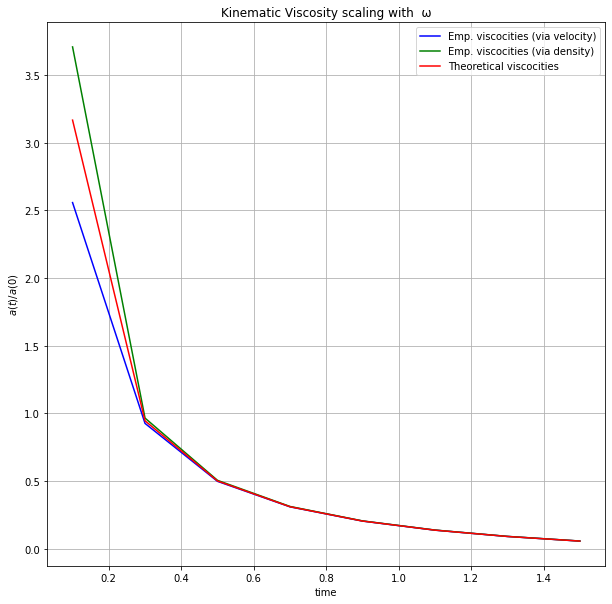

In [10]:
# fig, ax = plt.subplots(figsize=(10,10))


# nys_emp = []
# for a in amps_total:
#     def func(x, a):
#         return np.exp(-a*(2*np.pi/j_dim)**2*x)
#         # return np.exp(-a*x)
#     popt, pcov = curve_fit(func, np.arange(epochs), a[1]/a[1][0] )
#     nys_emp.append(popt[0])
# ax.plot(omegas,nys_emp,label='Emp. viscocities (via velocity)', color='blue')

# ax.plot(omegas,vs_emp,label='Emp. viscocities (via density)', color='green')
# vs_theo = 1/3*(1/omegas-0.5)
# ax.plot(omegas,vs_theo, label='Theoretical viscocities', color='red')
# ax.set_title("Kinematic Viscosity scaling with  ω")
# ax.set_xlabel('time')
# ax.set_ylabel('$a(t)/a(0)$')
# ax.legend()
# ax.grid()

# plt.show()

Stokes equation is appox for navies stokes equation

if raynolds number gets very high we cant drop

raynolds goes beyond 2000 there is turbulance --> then there is no f equilibrium anymore --> stockes equation is not valid anymore

raynolds number ~1000 is fine.
